# Objetivo

El objetivo de este notebook de Colab es desarrollar un modelo de machine learning sobre el dataset, a fines de poder predecir valores futuros de la serie temporal elegida, para el proyecto final de la certificación (hackaton)

>15/09/24
>
>Marco Mongi
>
>DS2402

# Importo librerías

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt  # Importamos pyplot para graficar


## Cargo el dataset desde drive
Va a pedir acceso a la cuenta de google
Lo siguiente lee un archivo desde drive, y carga el archivo Dataset.csv en el entorno de ejecución

In [2]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link='https://drive.google.com/file/d/1NboG0z-qVZuTx0qKMScZFm0UPJt_Do4_'
fluff, id = link.split('d/')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('processed_dataset.csv')

## Cargo dataset

In [3]:
# Asigno el contenido del csv a un dataframe
df = pd.read_csv('processed_dataset.csv',sep=',')

In [4]:
# Muestro los primeros 20 elementos del dataset (sin procesar)
df.head()

,date,Consumption,hour,day_of_week,month
0,2006-12-16 17:24:00,4.236671,17,5,12
1,2006-12-16 17:25:00,5.377704,17,5,12
2,2006-12-16 17:26:00,5.397025,17,5,12
3,2006-12-16 17:27:00,5.411335,17,5,12
4,2006-12-16 17:28:00,3.703828,17,5,12


In [5]:
df.describe()

,Consumption,hour,day_of_week,month
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.108175e+00,1.150076e+01,2.998909e+00,6.450359e+00
std,1.047192e+00,6.922227e+00,2.000064e+00,3.415762e+00
min,7.600000e-02,0.000000e+00,0.000000e+00,1.000000e+00
25%,3.330165e-01,6.000000e+00,1.000000e+00,3.000000e+00
50%,6.452317e-01,1.200000e+01,3.000000e+00,6.000000e+00
75%,1.538295e+00,1.800000e+01,5.000000e+00,9.000000e+00
max,1.112336e+01,2.300000e+01,6.000000e+00,1.200000e+01


In [6]:
df.dtypes

,0
date,object
Consumption,float64
hour,int64
day_of_week,int64
month,int64


## Proceso dataset

In [7]:
# Cambiamos los tipos de datos para asegurar el manejo adecuado de las columnas
df = df.astype({
    'date': 'datetime64[ns]',  # Fecha y hora exacta de la medición
    'Consumption': float,      # Consumo energético en kW
    'hour': int,               # Hora del día de la medición
    'day_of_week': int,        # Día de la semana
    'month': int               # Mes del año
})

In [8]:
# Resampling
freq='1H'
df=df.resample(freq,on='date').mean()
df.reset_index(inplace=True)

In [9]:
df.set_index('date', inplace=True)

In [10]:
df.head()

,Consumption,hour,day_of_week,month
date,,,,
2006-12-16 17:00:00,4.235039,17.0,5.0,12.0
2006-12-16 18:00:00,3.633753,18.0,5.0,12.0
2006-12-16 19:00:00,3.401852,19.0,5.0,12.0
2006-12-16 20:00:00,3.269883,20.0,5.0,12.0
2006-12-16 21:00:00,3.058049,21.0,5.0,12.0


# Train/Test Split
Voy a hacer el split en base a una fecha, dejando como datos de test de 2010 en adelante (2006-2010 entrenamiento)

In [11]:
# Divido dataset en variables a predecir y predictores
X = df[['hour', 'day_of_week', 'month']] # Predictores
y = df['Consumption'] # Variable a predecir

In [12]:
def train_test_split_from_date_rf(df, split_date):
    """
    Divide el DataFrame en conjuntos de entrenamiento y prueba en base a una fecha utilizando el índice como fecha.

    Parámetros:
    - df: DataFrame original que contiene las columnas 'hour', 'day_of_week', 'month', y 'Consumption'.
          El índice debe ser una columna datetime.
    - split_date: String que representa la fecha en formato 'YYYY-MM-DD HH:MM:SS'.

    Retorna:
    - X_train: DataFrame con los predictores para el conjunto de entrenamiento.
    - X_test: DataFrame con los predictores para el conjunto de prueba.
    - y_train: Serie con la variable objetivo para el conjunto de entrenamiento.
    - y_test: Serie con la variable objetivo para el conjunto de prueba.
    """
    # Convertir el índice a datetime si no lo está
    df.index = pd.to_datetime(df.index)

    # Dividir el DataFrame en conjunto de entrenamiento y prueba usando el índice
    train = df[df.index < split_date]
    test = df[df.index >= split_date]

    # Definir predictores y variable objetivo
    X_train = train[['hour', 'day_of_week', 'month']]
    y_train = train['Consumption']
    X_test = test[['hour', 'day_of_week', 'month']]
    y_test = test['Consumption']

    return X_train, X_test, y_train, y_test

In [13]:
# Realizar el split en base a una fecha
split_date = '2010-01-01 00:00:00'
X_train, X_test, y_train, y_test = train_test_split_from_date_rf(df, split_date)

# Mostrar las formas de los conjuntos de datos resultantes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (26671, 3)
X_test shape: (7918, 3)
y_train shape: (26671,)
y_test shape: (7918,)


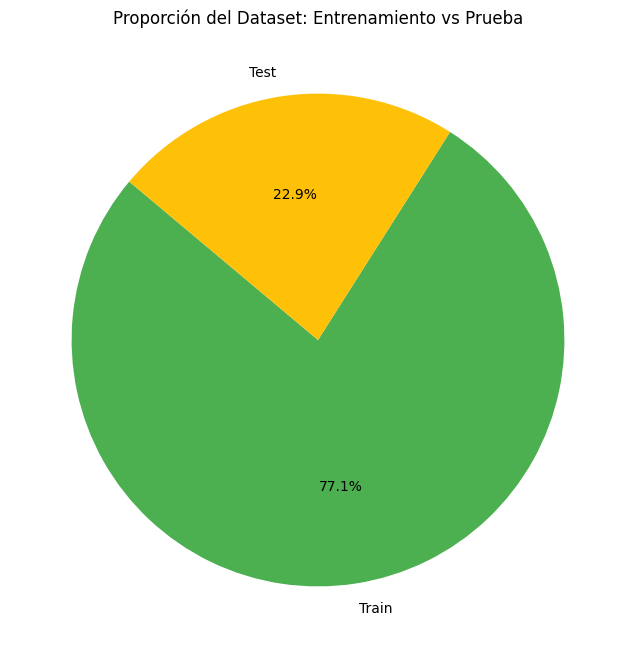

In [14]:
# Calcular los tamaños
size_train = len(X_train)  # Tamaño del conjunto de entrenamiento
size_test = len(X_test)     # Tamaño del conjunto de prueba
total_size = size_train + size_test       # Tamaño total del dataset

# Proporciones para el gráfico
proportions = [size_train / total_size, size_test / total_size]

# Etiquetas para el gráfico
labels = ['Train', 'Test']

# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(proportions, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#4CAF50', '#FFC107'])
plt.title('Proporción del Dataset: Entrenamiento vs Prueba')
plt.show()

In [15]:
print("Tamaño dataset original: ", df.shape)
print("Tamaño X_train: ", X_train.shape)
print("Tamaño y_train: ", y_train.shape)

Tamaño dataset original:  (34589, 4)
Tamaño X_train:  (26671, 3)
Tamaño y_train:  (26671,)


# Modelo Random Forest

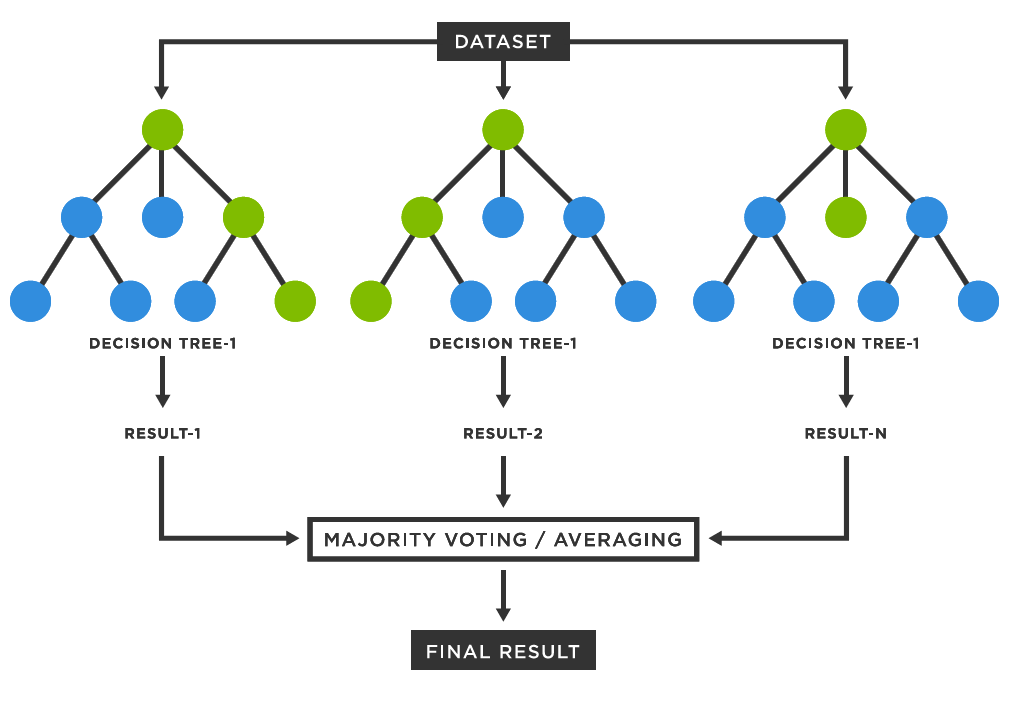

In [16]:
# Creamos una instancia del modelo de Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo

In [17]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

**Guardar/cargar el modelo entrenado**

In [18]:
# from joblib import dump, load

# # Guardar el modelo a un archivo
# dump(model, 'random_forest_model.joblib')

# # Cargar el modelo desde el archivo
# model = load('random_forest_model.joblib')

['random_forest_model.joblib']

## Pruebas con el modelo

In [19]:
# Predicciones
predictions = model.predict(X_test)

# Creamos un DataFrame para las predicciones con el índice temporal correcto
predictions_df = pd.DataFrame(data=predictions, index=X_test.index, columns=['Predicted'])

## Grafico


In [20]:
def evaluar_modelo_rf(dates, predicted_values, real_values, horizontes):
    """
    Evalúa un modelo de Random Forest (u otro modelo) en diferentes horizontes temporales.

    Parámetros:
    - dates: array con las fechas de las predicciones y valores reales.
    - predicted_values: array con los valores predichos.
    - real_values: array con los valores reales.
    - horizontes: lista de strings que indican los horizontes temporales (por ejemplo, ['1D', '1W', '1M']).

    Retorna:
    - Diccionario con el MSE para cada horizonte.
    """
    resultados = {}

    # Convertir los arrays a DataFrame para manipulación más fácil
    df = pd.DataFrame({
        'ds': pd.to_datetime(dates),
        'pred': predicted_values,
        'real': real_values
    })

    # Definir la fecha de inicio de las predicciones
    inicio_prediccion = df['ds'].iloc[0]

    for horizonte in horizontes:
        # Determinar el delta de tiempo según el horizonte
        if horizonte == '1D':
            delta = pd.Timedelta(days=1)
        elif horizonte == '1W':
            delta = pd.Timedelta(weeks=1)
        elif horizonte == '1M':
            delta = pd.Timedelta(days=30)
        elif horizonte == '3M':
            delta = pd.Timedelta(days=90)
        elif horizonte == '6M':
            delta = pd.Timedelta(days=180)
        elif horizonte == 'test completo':
            delta = df['ds'].iloc[-1] - inicio_prediccion
        else:
            print(f"Horizonte {horizonte} no reconocido.")
            continue

        # Definir el fin del horizonte de predicción
        fin_prediccion = inicio_prediccion + delta

        # Filtrar las predicciones y valores reales para el horizonte actual
        df_horizon = df[(df['ds'] > inicio_prediccion) & (df['ds'] <= fin_prediccion)]

        # Obtener los valores predichos y reales
        predicted = df_horizon['pred']
        actual = df_horizon['real']

        # Calcular el MSE
        mse = mean_squared_error(actual, predicted)
        resultados[horizonte] = mse

        # Graficar los valores predichos y reales
        plt.figure(figsize=(12, 6))
        plt.plot(df_horizon['ds'], actual, label='Valor Real')
        plt.plot(df_horizon['ds'], predicted, label='Predicción')
        plt.xlabel('Fecha')
        plt.ylabel('Consumo de Energía')
        plt.title(f'Predicción vs Real - Horizonte: {horizonte}')
        plt.legend()
        plt.show()

        print(f"MSE para el horizonte {horizonte}: {mse:.4f}")

    return resultados

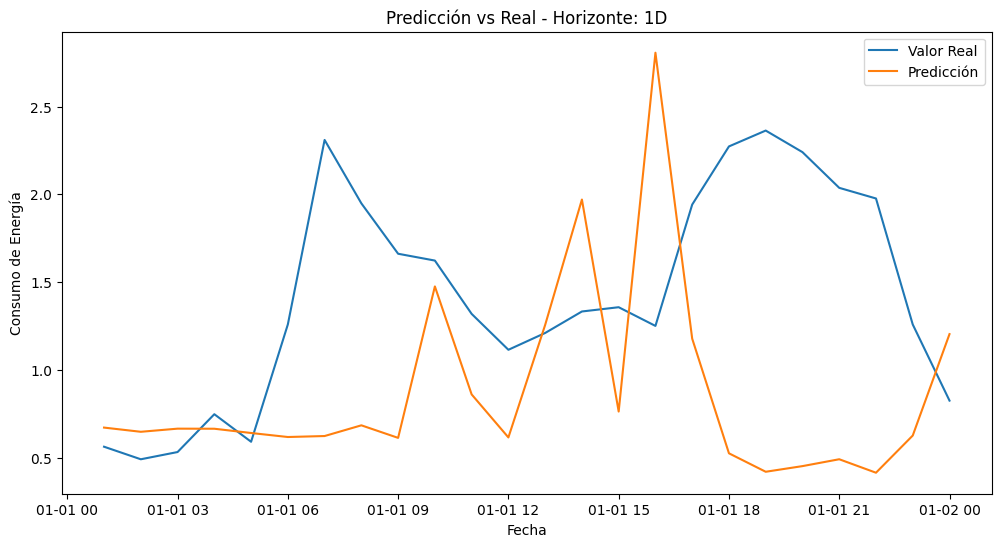

MSE para el horizonte 1D: 1.0693


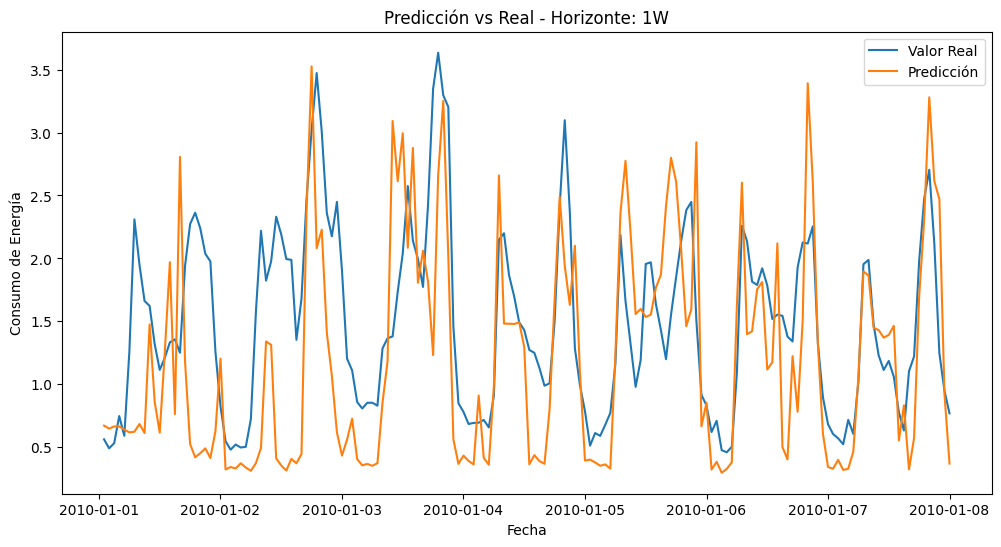

MSE para el horizonte 1W: 0.6050


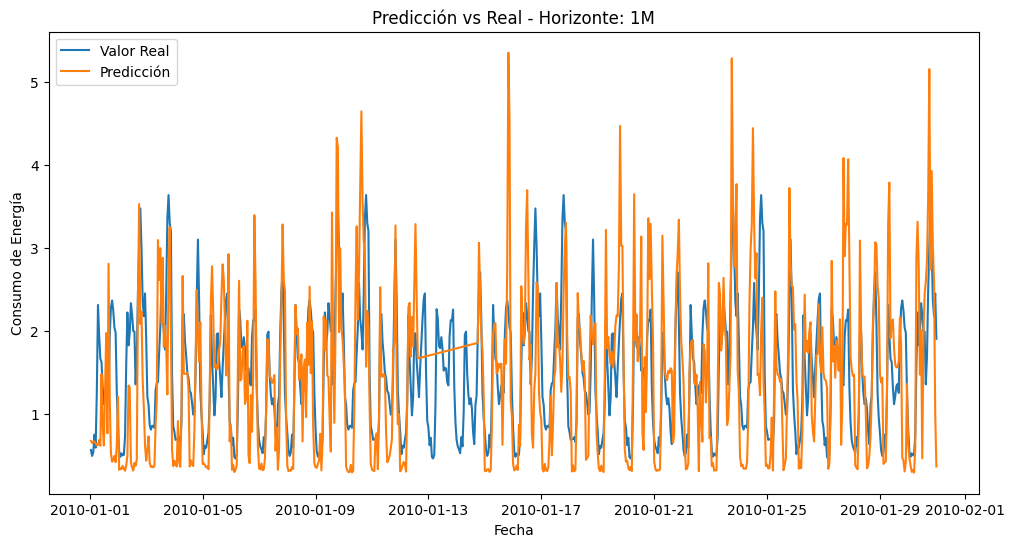

MSE para el horizonte 1M: 0.5767


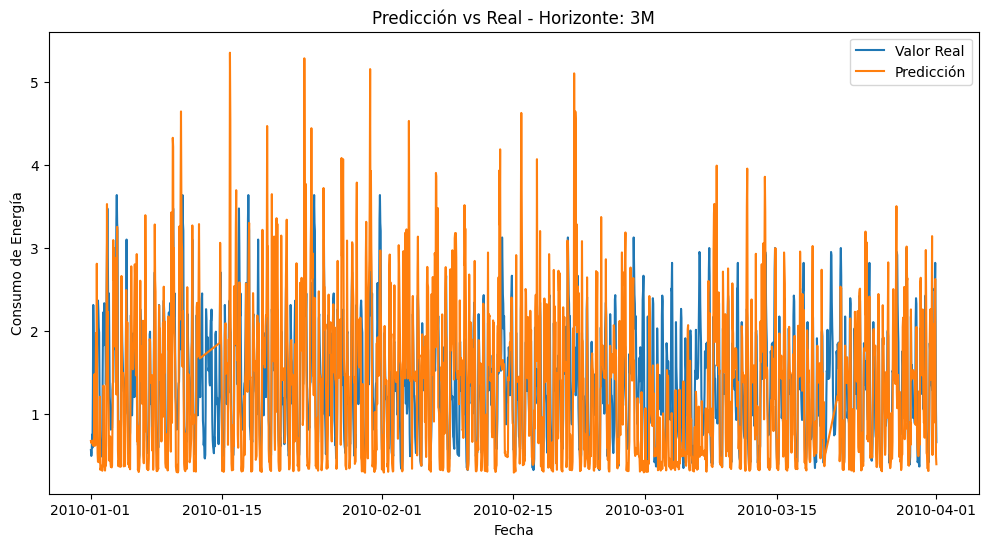

MSE para el horizonte 3M: 0.5298


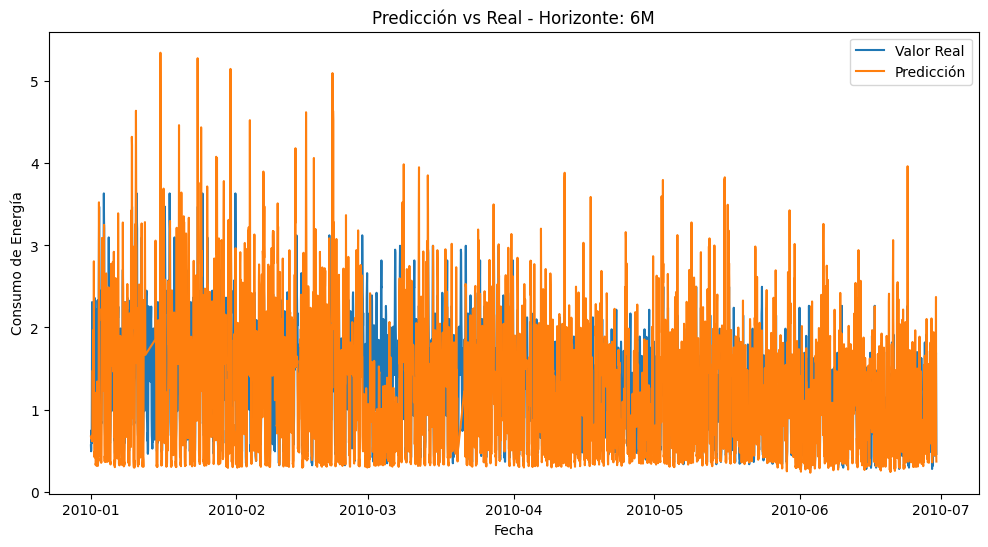

MSE para el horizonte 6M: 0.4396


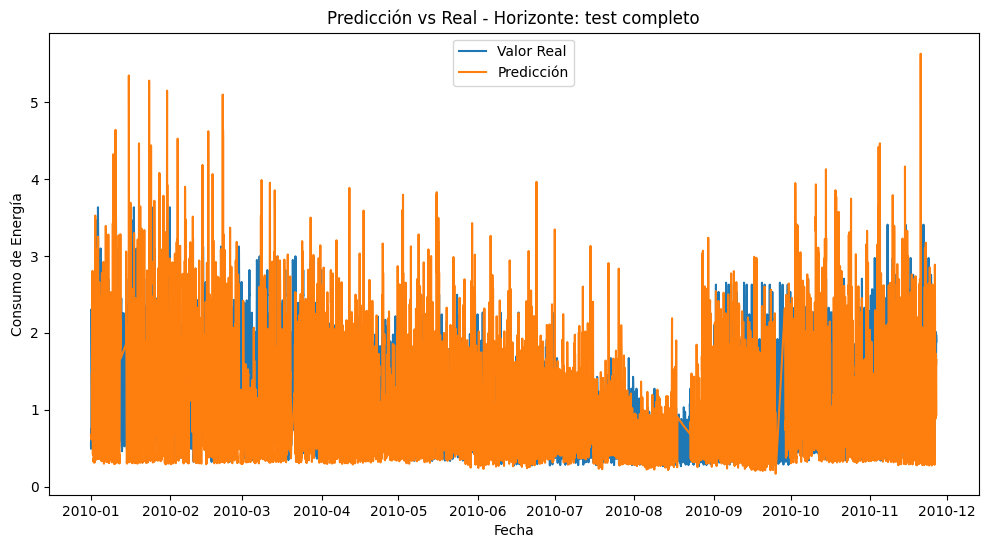

MSE para el horizonte test completo: 0.4140

Resultados de MSE por horizonte:
1D: 1.0693
1W: 0.6050
1M: 0.5767
3M: 0.5298
6M: 0.4396
test completo: 0.4140


In [21]:
dates = y_test.index.values
predicted_values = y_test.values
real_values = predictions_df.values[:,0]

# Definir los horizontes temporales que quieres evaluar
horizontes = ['1D', '1W', '1M', '3M', '6M', 'test completo']

# Evaluar el modelo
resultados = evaluar_modelo_rf(dates, predicted_values, real_values, horizontes)

# Mostrar los resultados
print("\nResultados de MSE por horizonte:")
for horizonte, mse in resultados.items():
    print(f"{horizonte}: {mse:.4f}")


# Validar el modelo

In [22]:
# Calculamos diferentes métricas de error
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")
print(f"Error Porcentual Absoluto Medio (MAPE): {mape}")

Error Cuadrático Medio (MSE): 0.4139488994809409
Error Absoluto Medio (MAE): 0.46536022768315133
Error Porcentual Absoluto Medio (MAPE): 0.5935065116966564


1. **Error Cuadrático Medio (MSE - Mean Squared Error):** El MSE es una medida que eleva al cuadrado las diferencias entre los valores predichos y los reales, lo cual penaliza más los errores grandes. Un MSE de 0.6322725580965985 significa que, en promedio, el cuadrado de los errores de tus predicciones respecto a los valores reales es de aproximadamente 0.63. **Dado que el MSE está en la misma escala que el cuadrado de tu variable objetivo (en este caso, el consumo de energía en kW), puede ser difícil interpretar su magnitud sin contexto**. Un MSE más bajo indica un mejor ajuste del modelo a tus datos.

2. **Error Absoluto Medio (MAE - Mean Absolute Error):** El MAE proporciona una medida de cuán grande es el error en tus predicciones, en promedio. Un MAE de 0.5552547207571173 significa que, **en promedio, tus predicciones se desvían en aproximadamente 0.56 unidades de los valores reales**. A diferencia del MSE, el MAE no eleva al cuadrado los errores, por lo que no penaliza tanto los errores grandes. Es más robusto a outliers y a menudo **más fácil de interpretar, ya que está en la misma unidad que tu variable de predicción**.

3. **Error Porcentual Absoluto Medio (MAPE - Mean Absolute Percentage Error):** El MAPE expresa el error como un porcentaje del valor real y proporciona una visión relativa del error. Un MAPE de 0.8754870291059426 significa que, **en promedio, tus predicciones están fuera por un 87.5% en relación con el valor real**. Este número puede ser engañoso si tienes valores reales que están muy cerca de cero, ya que cualquier pequeño error en la predicción puede resultar en un porcentaje de error muy alto.

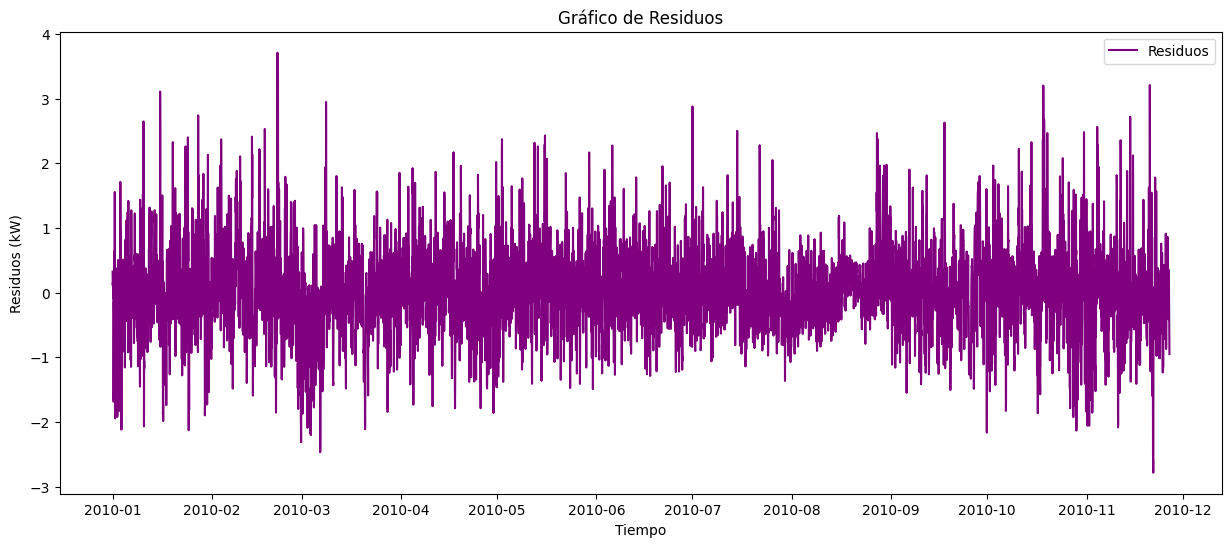

In [23]:
residuals = y_test - predictions

plt.figure(figsize=(15, 6))
plt.plot(residuals, label='Residuos', color='purple')
#plt.hlines(y=0, xmin=0, xmax=len(residuals), colors='black', linestyles='dashed', alpha=0.7)
plt.title('Gráfico de Residuos')
plt.xlabel('Tiempo')
plt.ylabel('Residuos (kW)')
plt.legend()
plt.show()

Se ve que:


*   El modelo predice valores más bajos que los reales (los residuos son más que nada positivos)
*   Hay diferencias de hasta 7kW



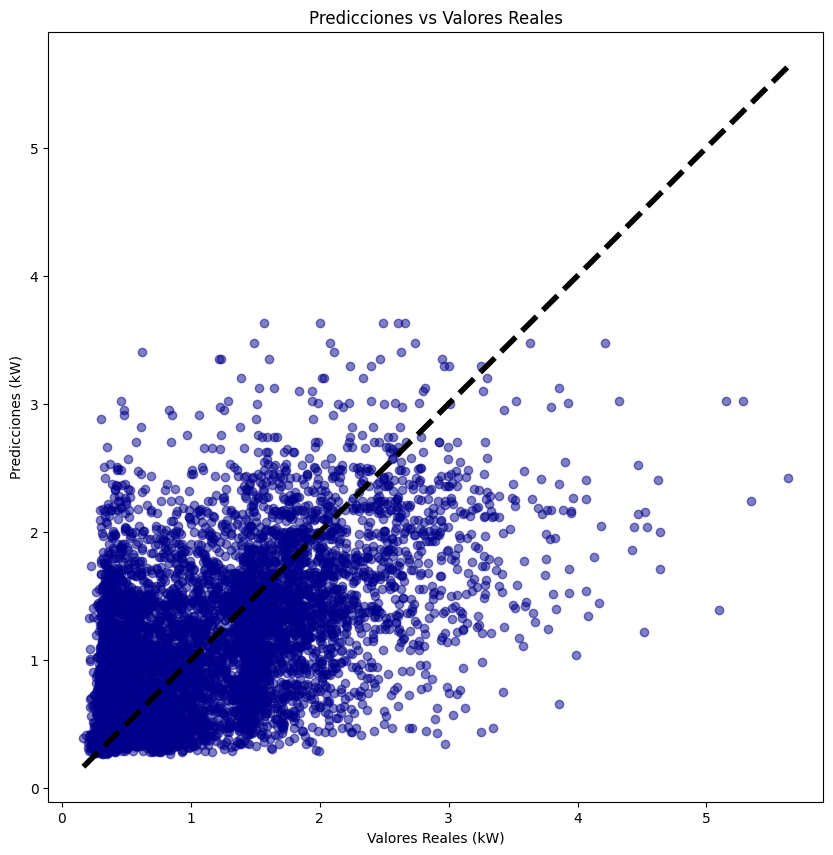

In [24]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, predictions, alpha=0.5, color='darkblue')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales (kW)')
plt.ylabel('Predicciones (kW)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

# Gradio

In [25]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.8 MB/s eta 0:00:00


In [29]:
import gradio as gr
from datetime import datetime

def plot_predictions(start_date, end_date):
    # Convertir las fechas de texto a objetos datetime
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    # Filtrar los datos según las fechas de entrada
    filtered_y_test = y_test[start_date:end_date]
    filtered_predictions = predictions_df.loc[start_date:end_date]

    # Crear el gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_y_test, label='Real Consumption', color='blue')
    plt.plot(filtered_predictions, label='Predicted Consumption', color='red', linestyle='--')
    plt.title('Consumo Real vs. Predicción')
    plt.xlabel('Fecha y Hora')
    plt.ylabel('Consumo (kW)')
    plt.legend()
    plt.grid(True)
    #plt.close()
    return plt

# Definir la interfaz de Gradio
iface = gr.Interface(fn=plot_predictions,
                     inputs=[gr.Textbox(label="Start Date", placeholder="YYYY-MM-DD (e.g. 2006-12-16)"),
                             gr.Textbox(label="End Date", placeholder="YYYY-MM-DD (e.g. 2010-11-26)")],
                     outputs=['plot'],
                     title="Consumo Energético: Real vs Predicción",
                     description="Selecciona un rango de fechas para visualizar el consumo energético real versus las predicciones.")

# Ejecutar la aplicación
iface.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:982: UserWarning: Cannot load dark. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/dark (Request ID: Root=1-66f96536-3b7262ad42e12a3905ee9ec7;3d0bb2b7-61a1-4467-b68c-172ac94ac5f5)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://5043296f260df5ca43.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5043296f260df5ca43.gradio.live
